ТЕМА: Классификация стилистического гендера в японском языке

ЦЕЛЬ — разработка модели автоматической классификации японских текстов по гендерной маркированности на основе лингвистических маркеров. Несмотря на отсутствие грамматической категории рода в японском языке, в речи носителей существуют устойчивые паттерны употребления частиц, местоимений и грамматических конструкций, позволяющие с определенной вероятностью идентифицировать гендерную принадлежность автора текста

ЗАДАЧИ: 1) исследовать лингвистические маркеры гендерной принадлежности в японском языке

2) разработать ML-модель для автоматической классификации речи по трем категориям: мужской, женский и нейтральный стиль речи

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
!pip install fugashi[unidic-lite]
!python -m unidic download
import fugashi
import requests

/usr/bin/python3: No module named unidic


ШАГ 1. Подготовка данных

1) Загружаем данные

In [ ]:
import requests
import pandas as pd
url = "https://docs.google.com/spreadsheets/d/1yC5dzrxstFdv_Tx8sjVWS8YFtgwgtsa8/export?format=xlsx"
response = requests.get(url)
with open("japanese.xlsx", "wb") as f:
    f.write(response.content)
df = pd.read_excel("japanese.xlsx")
print(df)

                                                   Текст          Пол  \
0                                         「私、これちょっと怖いわ…」      женский   
1                                  「そうだと思うの。だって、そうでしょう？」      мужской   
2                                         「あなた、また遅刻したのね」      мужской   
3                                        「このドレス、可愛いかしら？」      женский   
4                                         「あの人のこと、好きなのよ」      женский   
...                                                  ...          ...   
12367  「お供しましょう」清子の返事を聴いた下女は、立ち際に津田の方を見ながら「旦那様もいっしょにい...      мужской   
12368               「奥さん」と云おうとして、云い損なった彼はつい「清子さん」と呼び掛けた。      мужской   
12369                                  「あなたはいつごろまでおいでです」      мужской   
12370                         「そりゃ何とも云えないわ」清子はこう云って微笑した。      женский   
12371                                            夏目漱石、終り  нейтральный   

                                              Примечания  
0      Окончание ～わ — классический женский маркер эмо...  
1    

2) Анализируем датасет, чтобы проверить данные и их дисбаланс

Анализ распределения классов:

Количество примеров по классам:
Пол
мужской        6460
нейтральный    4346
женский        1566
Name: count, dtype: int64

Процентное соотношение:
Пол
мужской        52.21%
нейтральный    35.13%
женский        12.66%
Name: proportion, dtype: object


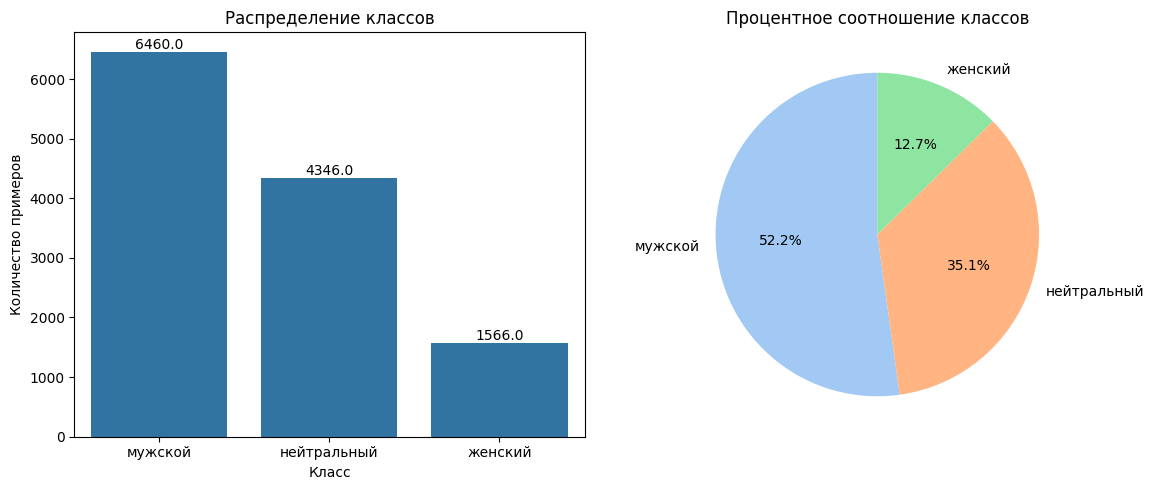

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Анализ распределения классов:")
class_distribution = df['Пол'].value_counts()
class_percentage = df['Пол'].value_counts(normalize=True) * 100

print("\nКоличество примеров по классам:")
print(class_distribution)
# в форме гистограммы
print("\nПроцентное соотношение:")
print(class_percentage.round(2).astype(str) + '%')
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
ax = sns.countplot(x='Пол', data=df, order=class_distribution.index)
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество примеров')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')
# Круговая диаграмма
plt.subplot(1, 2, 2)
plt.pie(class_distribution,
        labels=class_distribution.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('pastel'))
plt.title('Процентное соотношение классов')

plt.tight_layout()
plt.show()

Анализ показывает значительный дисбаланс в распределении классов: большинство примеров — мужской пол (52,2%), тогда как женский — всего около 12,7%, а нейтральный — примерно 35,1%. Такой дисбаланс может привести к переобучению модели на доминирующий класс и ухудшению её качества по другим классам.

Для этого нам в дальнейшем приедтся использовать методы балансировки данных, чтобы повысить представительность меньших классов и улучшить качество предсказаний по ним.

Следубщий важный этап - предобработка текста

Дисклеймер: Японский язык не использует пробелы между словами, поэтому токенизация обязательна! И для данного языка токенизация (разбиение текста на слова/морфемы) требует специализированных инструментов - мы будем использовать fugashi (обертка для MeCab).

Токенизация позволяет выделить частицы (например, わ, ぞ, ぜ — маркеры женской/мужской речи), местоимения (私, 僕, 俺), окончания глаголов (～だ vs. ～です), которые являются ключевыми для определения гендерного стиля.

Без токенизации анализ отдельных лингвистических единиц невозможен.

In [ ]:
# Обработка текста
tagger = fugashi.Tagger()

def tokenize_ja(text):
    return " ".join([word.surface for word in tagger(text)])

def lemmatize_ja(text):
    words = tagger(text)
    lemmas = []
    for word in words:
        lemma = word.feature.lemma if word.feature.lemma else word.surface
        lemmas.append(lemma)
    return " ".join(lemmas)

def clean_ja_text(text):
    text = re.sub(r'[＜＞「」【】『』〈〉()（）［］{}｛｝【】『』“”‘’]', '', text)
    text = re.sub(r'[。、・…]+', ' ', text)
    text = re.sub(r'[a-zA-Z0-9]', '', text)
    return text.strip()

df['tokenized_text'] = df['Текст'].apply(tokenize_ja)
df['cleaned_text'] = df['tokenized_text'].apply(clean_ja_text)
df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_ja)


In [ ]:
print("Обработанный текст:")
for i, row in df.head().iterrows():
    print(f"\nОригинальный текст {i+1}:")
    print(row['Текст'])
    print("\nТокенизированный текст:")
    print(row['tokenized_text'])
    print("\nОчищенный текст:")
    print(row['cleaned_text'])
    print("\nЛемматизированный текст:")
    print(row['lemmatized_text'])

Обработанный текст:

Оригинальный текст 1:
「私、これちょっと怖いわ…」

Токенизированный текст:
「 私 、 これ ちょっと 怖い わ … 」

Очищенный текст:
私   これ ちょっと 怖い わ

Лемматизированный текст:
私-代名詞 此れ 一寸 怖い わ

Оригинальный текст 2:
「そうだと思うの。だって、そうでしょう？」

Токенизированный текст:
「 そう だ と 思う の 。 だ って 、 そう でしょう ？ 」

Очищенный текст:
そう だ と 思う の   だ って   そう でしょう ？

Лемматизированный текст:
そう だ と 思う の だ って そう です ？

Оригинальный текст 3:
「あなた、また遅刻したのね」

Токенизированный текст:
「 あなた 、 また 遅刻 し た の ね 」

Очищенный текст:
あなた   また 遅刻 し た の ね

Лемматизированный текст:
貴方 又 遅刻 為る た の ね

Оригинальный текст 4:
「このドレス、可愛いかしら？」

Токенизированный текст:
「 この ドレス 、 可愛い かしら ？ 」

Очищенный текст:
この ドレス   可愛い かしら ？

Лемматизированный текст:
此の ドレス-dress 可愛い かしら ？

Оригинальный текст 5:
「あの人のこと、好きなのよ」

Токенизированный текст:
「 あの 人 の こと 、 好き な の よ 」

Очищенный текст:
あの 人 の こと   好き な の よ

Лемматизированный текст:
あの 人 の 事 好き だ の よ


Создаем функцию extract_gender_features, которая ищет в тексте специфические языковые маркеры, характерные для каждого гендерного стиля, используя регулярные выражения

In [ ]:
# Извлечение ручных признаков
def extract_gender_features(text):
    male_all = r'俺|おれ|僕|ぼく|儂|わし|我輩|吾輩|わがはい|俺様|おれさま|お前|おまえ|貴様|きさま|手前|てまえ|ぜ|ぞ|い(?![ぁ-ん])|な(?![ぁ-ん])|かい\b|よな\b|だ(?![ぁ-ん])|だろう\b|のだ\b|んだ\b|ものか\b|(て|で)やがる\b|くせに\b'
    female_all = r'あたし|あたい|あたくし|貴方|あなた|わ(?![ぁ-ん])|わよ\b|わね\b|の(?![ぁ-ん])|のよ\b|のね\b|かしら\b|こと\b|たら\b|ですわ\b|ますわ\b|ございます\b|てよ\b|ちゃう\b'
    neutral_all = r'私|わたし|わたくし|自分|じぶん|君|きみ|そちら|よ(?![ぁ-ん])|ね\b|よね\b|かな\b|(?<!わ)です\b|(?<!わ)ます\b|でしょう\b|かもしれません\b|と思い\b|と考え\b|と言う\b'
    return {
        'male_markers': len(re.findall(male_all, text)),
        'female_markers': len(re.findall(female_all, text)),
        'neutral_markers': len(re.findall(neutral_all, text))
    }

gender_features = df['Текст'].apply(extract_gender_features).apply(pd.Series)
df = pd.concat([df, gender_features], axis=1)


Разделяем данных на обучающую и тестовую выборки для обучения модели классификации гендерного стиля

In [ ]:
# Разделение данных
X_text = df['cleaned_text']
X_manual = df[['male_markers', 'female_markers', 'neutral_markers']]
y = df['Пол']

X_train_text, X_test_text, X_train_manual, X_test_manual, y_train, y_test = train_test_split(
    X_text, X_manual, y, test_size=0.3, stratify=y, random_state=42
)

Выполняем  векторизацию текстовых данных — преобразование текста в числовой формат, который может обработать модель машинного обучения

TF-IDF (Term Frequency-Inverse Document Frequency) — это статистическая мера, которая оценивает важность слова в документе относительно всего корпуса. Она состоит из двух частей: TF (частота термина) и IDF (обратная частота документа).

Для нашей задачи он хорошо подходит потому что:
Выделяет именно те слова, которые маркируют гендер
Гендерные различия в японском часто выражаются мелкими, но частотными лингвистическими паттернами

$IDF(t, D) = \log \left( \frac{N}{\text{документов с } t} \right)$

где N - общее количество документов

In [ ]:
# Проводим векторизацию текста
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)

In [ ]:
# Преобразуем разреженную матрицы в плотный массив (для наглядности)
dense_array = X_train_vec[:5].toarray()  # Первые 5 документов
print("Первые 5 векторов (первые 10 признаков):")
print(dense_array[:, :10])

Первые 5 векторов (первые 10 признаков):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
# Проверка, есть ли ненулевые элементы во всей матрице
print("Всего ненулевых элементов:", X_train_vec.nnz)
print("Ненулевые элементы в первых 5 документах:")
for i in range(5):
    print(f"Документ {i}:", X_train_vec[i].nonzero()[1])

Всего ненулевых элементов: 46449
Ненулевые элементы в первых 5 документах:
Документ 0: [820 844]
Документ 1: [180 654 187]
Документ 2: [405 251 111]
Документ 3: [748  86 670 286 866 803]
Документ 4: [196  87 871 609 368  42  55 264 198]


Получается, что в первом случае мы имеем дело с редкими словами/комбинациями.

А теперь боремся с дисбалансом классов!!! используем SMOTE для создания синтетических примеров

In [ ]:
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# Стандартизируем только ручные признаки (не TF-IDF!!)
scaler = StandardScaler()
X_train_manual_scaled = scaler.fit_transform(X_train_manual)
X_test_manual_scaled = scaler.transform(X_test_manual)
X_train_combined = np.hstack([X_train_vec.toarray(), X_train_manual_scaled])
X_test_combined = np.hstack([X_test_vec.toarray(), X_test_manual_scaled])
# SMOTE с настройками для уменьшения переобучения
smote = SMOTE(
    random_state=42,
    k_neighbors=3,
    sampling_strategy={'женский': 2000, 'нейтральный': 4000}
)
X_train_res, y_train_res = smote.fit_resample(X_train_combined, y_train)

ШАГ 2.1 Обучение модели

*используем стратегию One-vs-Rest, которая разбивает многоклассовую задачу на несколько бинарных задач. Для каждого класса создается отдельная бинарная модель.

Формулы:

Accuracy (Точность) Accuracy = (Σ Правильных предсказаний) / (Всего примеров)
Precision (Точность для каждого класса) Precision = TP / (TP + FP) Для многоклассовой классификации:
Вычисляется для каждого класса отдельно (мужской/женский/нейтральный)

Затем может усредняться (macro/micro averaging)

Recall (Полнота) Формула: Recall = TP / (TP + FN) Для многоклассовой классификации: Аналогично precision, вычисляется для каждого класса.
F1-Score (Гармоническое среднее) Формула: F1 = 2 * (Precision * Recall) / (Precision + Recall) Для многоклассовой классификации: Вычисляется для каждого класса, затем усредняется.
ROC-AUC (Площадь под ROC-кривой) Для многоклассовой классификации: Обычно используется один из подходов:
One-vs-Rest (OvR): Строится отдельная ROC-кривая для каждого класса против всех остальных

Macro-average: Усреднение AUC по всем классам

Weighted-average: Усреднение с учётом размера классов


ОБУЧЕНИЕ БАЗОВЫХ МОДЕЛЕЙ БЕЗ ПОДБОРА ПАРАМЕТРОВ

Обучение базовой модели: LogisticRegression
Accuracy: 0.8012
F1-score: 0.8069
ROC-AUC: 0.8399
Precision: 0.8213
Recall: 0.8012


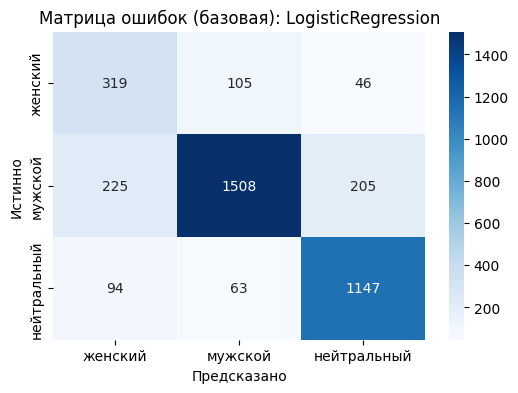


Обучение базовой модели: RandomForest
Accuracy: 0.8335
F1-score: 0.8296
ROC-AUC: 0.8312
Precision: 0.8289
Recall: 0.8335


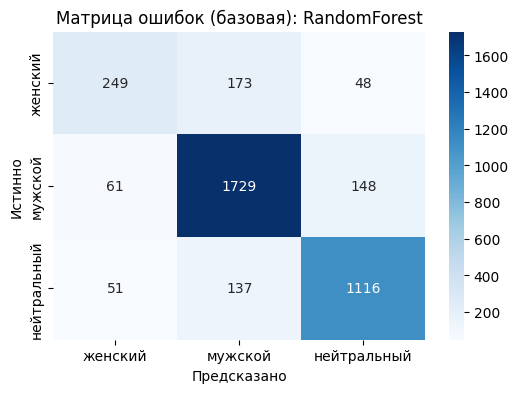

In [ ]:
# 1. Базовые модели без подбора гиперпараметров
base_models = {
    'LogisticRegression': LogisticRegression(max_iter=500, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')
}

print("\nОБУЧЕНИЕ БАЗОВЫХ МОДЕЛЕЙ БЕЗ ПОДБОРА ПАРАМЕТРОВ")
base_results = []

for name, model in base_models.items():
    print(f"\nОбучение базовой модели: {name}")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_combined)

    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), multi_class='ovr')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Матрица ошибок (базовая): {name}')
    plt.xlabel('Предсказано')
    plt.ylabel('Истинно')
    plt.show()

    base_results.append({
        'model_name': name,
        'accuracy': accuracy,
        'f1': f1,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall
    })

ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ Основной показатель - 1508 - правильно предсказанных мужских текстов. Заметны ошибки: модель часто путает женские тексты с мужскими, а также мужские тексты с нейтральными (205). Наилучший результат предсказания для мужских текстов (1518).

RANDOM FOREST Матрица ошибок для RandomForest показывает еще больше правильно предсказанных мужских текстов (1729), что лучше, чем у Logistic Regression. Уменьшилось количество ошибок при определении женского текста, как мужской. Есть небольшие проблемы при определении нейтральных текстов, которые часто путаются с мужскими (137). RandomForest показывает себя как более точная модель для этой задачи

ШАГ 2.2. Переобучение модели с гиперпараметрами

In [ ]:
from sklearn.model_selection import GridSearchCV

# 2. Модели с подбором гиперпараметров
models_params = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=500, class_weight='balanced', random_state=42),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10],
            'solver': ['liblinear'],
            'penalty': ['l1', 'l2']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 10],
            'min_samples_split': [2, 5, 10]
        }
    }
}


Обучение модели с подбором параметров: LogisticRegression
Лучшие параметры: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.8327
F1-score: 0.8334
ROC-AUC: 0.8497
Precision: 0.8364
Recall: 0.8327


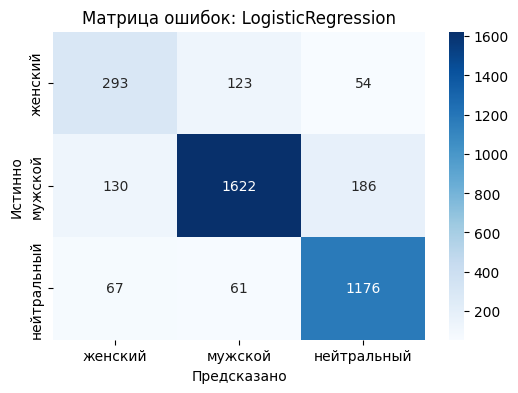


Обучение модели с подбором параметров: RandomForest
Лучшие параметры: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.8408
F1-score: 0.8365
ROC-AUC: 0.8369
Precision: 0.8367
Recall: 0.8408


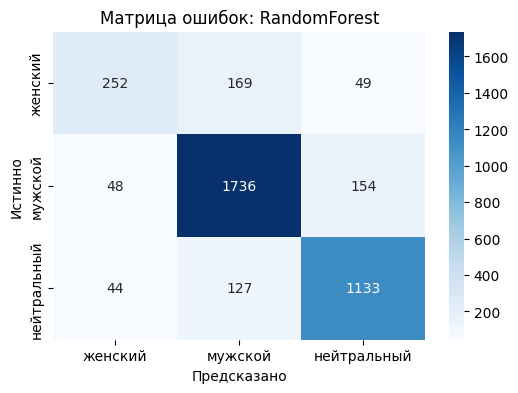

In [ ]:
results = []
for name, mp in models_params.items():
    print(f"\nОбучение модели с подбором параметров: {name}")
    clf = GridSearchCV(mp['model'], mp['params'], scoring='f1_weighted', cv=3, n_jobs=-1)
    clf.fit(X_train_res, y_train_res)
    y_pred = clf.predict(X_test_combined)

    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), multi_class='ovr')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    print(f"Лучшие параметры: {clf.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
    plt.title(f'Матрица ошибок: {name}')
    plt.xlabel('Предсказано')
    plt.ylabel('Истинно')
    plt.show()

    results.append({
        'model_name': name,
        'best_params': clf.best_params_,
        'accuracy': accuracy,
        'f1': f1,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall
    })

In [ ]:
# Сравнение результатов
base_results_df = pd.DataFrame(base_results)
results_df = pd.DataFrame(results)

print("\nСРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
for model_name in base_results_df['model_name']:
    base = base_results_df[base_results_df['model_name'] == model_name].iloc[0]
    optimized = results_df[results_df['model_name'] == model_name].iloc[0]

    print(f"\nМодель: {model_name}")
    print(f"Accuracy: {base['accuracy']:.4f} (базовая) -> {optimized['accuracy']:.4f} (оптимизированная)")
    print(f"F1-score: {base['f1']:.4f} (базовая) -> {optimized['f1']:.4f} (оптимизированная)")
    print(f"ROC-AUC: {base['roc_auc']:.4f} (базовая) -> {optimized['roc_auc']:.4f} (оптимизированная)")
    print(f"Precision: {base['precision']:.4f} (базовая) -> {optimized['precision']:.4f} (оптимизированная)")
    print(f"Recall: {base['recall']:.4f} (базовая) -> {optimized['recall']:.4f} (оптимизированная)")


СРАВНЕНИЕ РЕЗУЛЬТАТОВ:

Модель: LogisticRegression
Accuracy: 0.8012 (базовая) -> 0.8327 (оптимизированная)
F1-score: 0.8069 (базовая) -> 0.8334 (оптимизированная)
ROC-AUC: 0.8399 (базовая) -> 0.8497 (оптимизированная)
Precision: 0.8213 (базовая) -> 0.8364 (оптимизированная)
Recall: 0.8012 (базовая) -> 0.8327 (оптимизированная)

Модель: RandomForest
Accuracy: 0.8335 (базовая) -> 0.8408 (оптимизированная)
F1-score: 0.8296 (базовая) -> 0.8365 (оптимизированная)
ROC-AUC: 0.8312 (базовая) -> 0.8369 (оптимизированная)
Precision: 0.8289 (базовая) -> 0.8367 (оптимизированная)
Recall: 0.8335 (базовая) -> 0.8408 (оптимизированная)



СРАВНЕНИЕ МОДЕЛЕЙ С ПРИРОСТОМ:


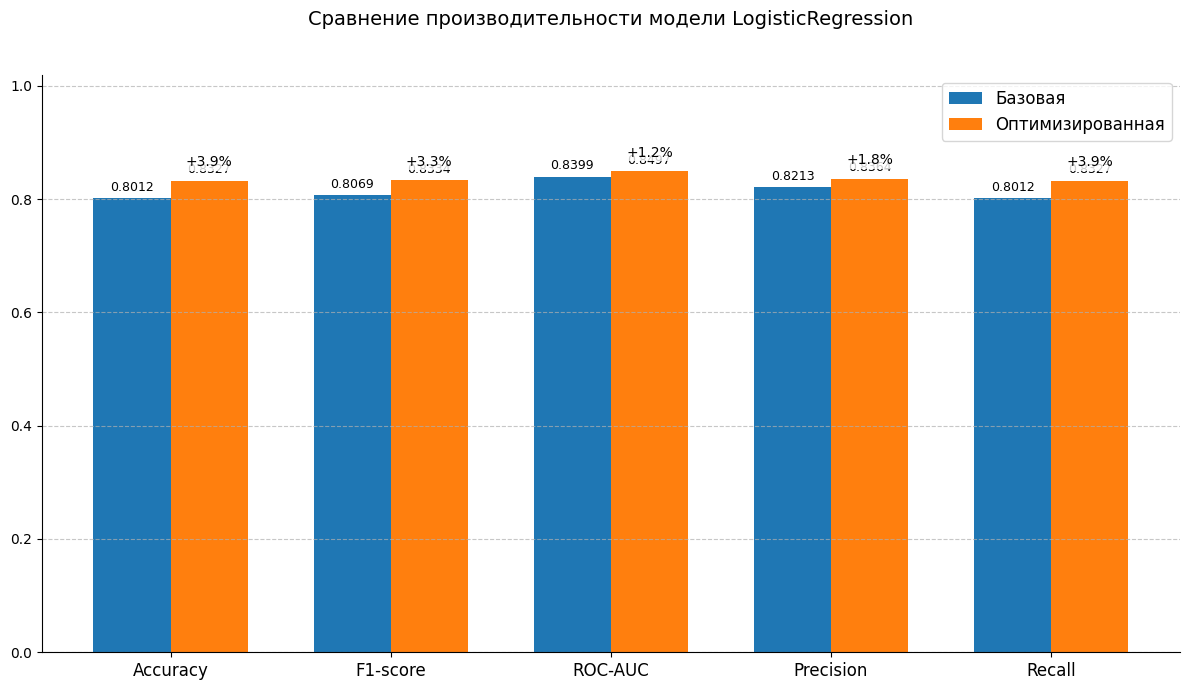

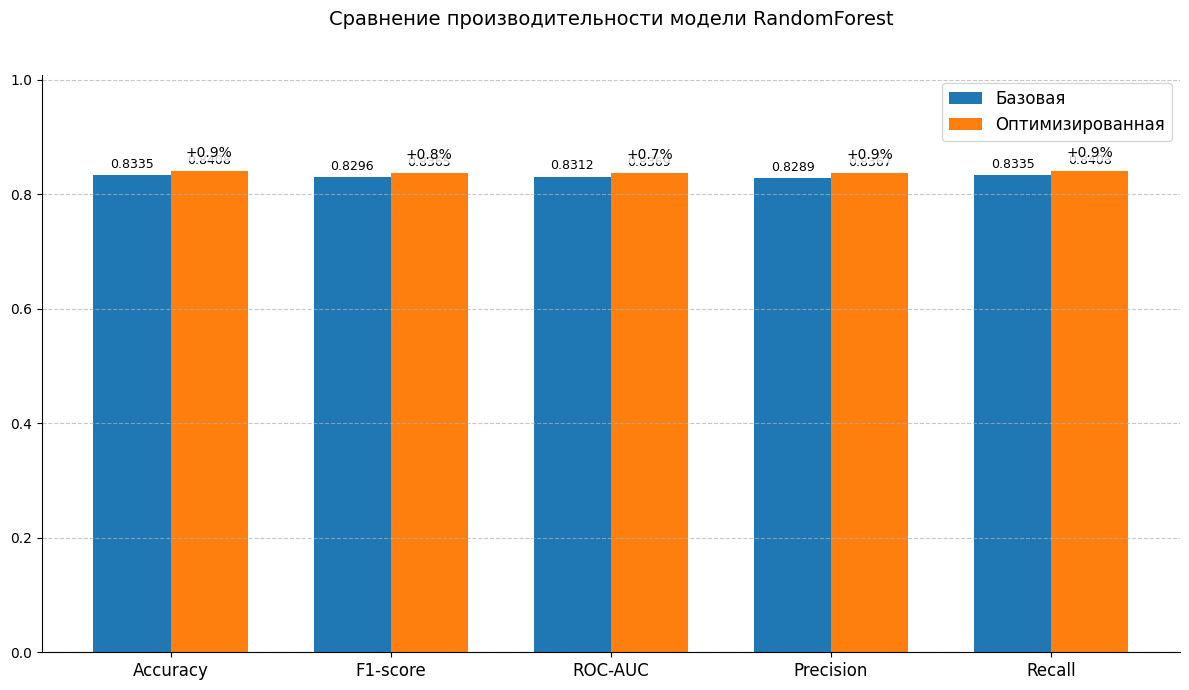

In [ ]:
def compare_models_visual(base_results_df, results_df):
    for model_name in base_results_df['model_name']:
        base = base_results_df[base_results_df['model_name'] == model_name].iloc[0]
        optimized = results_df[results_df['model_name'] == model_name].iloc[0]

        # Метрики для сравнения
        metrics = ['accuracy', 'f1', 'roc_auc', 'precision', 'recall']
        metric_names = ['Accuracy', 'F1-score', 'ROC-AUC', 'Precision', 'Recall']
        base_values = [base[m] for m in metrics]
        optimized_values = [optimized[m] for m in metrics]
        improvements = [(opt - base) / base * 100 if base != 0 else 0
                       for base, opt in zip(base_values, optimized_values)]
        fig, ax = plt.subplots(figsize=(12, 7))
        bar_width = 0.35
        index = np.arange(len(metrics))
        bars1 = ax.bar(index, base_values, bar_width, label='Базовая', color='#1f77b4')
        bars2 = ax.bar(index + bar_width, optimized_values, bar_width, label='Оптимизированная', color='#ff7f0e')

        def add_values(bars, values):
            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax.annotate(f'{value:.4f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=9)

        add_values(bars1, base_values)
        add_values(bars2, optimized_values)
        for i, (imp, opt_val) in enumerate(zip(improvements, optimized_values)):
            if imp != 0:
                ax.text(index[i] + bar_width, opt_val + 0.02,
                        f'{imp:+.1f}%',
                        ha='center', va='bottom', fontsize=10,
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1))
        ax.set_title(f'Сравнение производительности модели {model_name}\n', fontsize=14, pad=20)
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(metric_names, fontsize=12)
        ax.set_ylim(0, max(max(base_values), max(optimized_values)) * 1.2)
        ax.legend(fontsize=12)
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.tight_layout()
        plt.show()

print("\nСРАВНЕНИЕ МОДЕЛЕЙ С ПРИРОСТОМ:")
compare_models_visual(base_results_df, results_df)

Показали улучшились после подбора гиперпараметров (в частности благодаря правильной предобработке и стандартизации)


Изначально проводилось сравнение без стандартизации - результаты у логистической регрессии падали, а у "случайного леса" увеличивались. Делаем вывод: он меньше зависит от масштаба признаков, чем ЛогРег, поэтому эффект от стандартизации не такой драматичный. Тем не менее, небольшое улучшение производительности - это всегда хорошо.

И в целом, обе модели показывают хорошую производительность (Accuracy и F1-score выше 0.8), что говорит о том, что они успешно справляются с задачей классификации.

In [ ]:
# Выбираем модель с наивысшим F1-score
best_model_info = max(base_results, key=lambda x: x['f1'])
best_model_name = best_model_info['model_name']
best_model = base_models[best_model_name]

print(f"Лучшая модель: {best_model_name}")
print(f"F1-score: {best_model_info['f1']:.4f}")
print(f"Accuracy: {best_model_info['accuracy']:.4f}")
print(f"ROC-AUC: {best_model_info['roc_auc']:.4f}")

Лучшая модель: RandomForest
F1-score: 0.8296
Accuracy: 0.8335
ROC-AUC: 0.8312


In [ ]:
# Создаем DataFrame с тестовыми данными и предсказаниями
test_results = pd.DataFrame({
    'text': X_test_text,
    'true_label': y_test,
    'predicted_label': best_model.predict(X_test_combined)
})
probabilities = best_model.predict_proba(X_test_combined)
for i, class_name in enumerate(best_model.classes_):
    test_results[f'prob_{class_name}'] = probabilities[:, i]
prob_matrix = probabilities.copy()
prob_matrix.sort(axis=1)
test_results['confidence'] = prob_matrix[:, -1] - prob_matrix[:, -2]

test_results.sample(5)  # Показываем 5 случайных примеров

,text,true_label,predicted_label,prob_женский,prob_мужской,prob_нейтральный,confidence
9343,彼 は いつ か 真面目 に こんな 質問 を 彼女 に かけ て 見 た 事 が あっ た,мужской,мужской,0.046516,0.791765,0.161719,0.630046
12234,それ で は 僕 が 何 の ため に あなた を 廊下 の 隅 で 待ち伏せ て い ...,мужской,мужской,0.080000,0.860000,0.060000,0.780000
10178,ただ 口 へ 入る から 旨い だけ の 事 な ん だ だ って それ じゃ なぜ 旨...,мужской,мужской,0.060000,0.920000,0.020000,0.860000
4173,また 宅 へ 帰っ た,нейтральный,нейтральный,0.000000,0.020000,0.980000,0.960000
55,この 古い 街角 に は いつ も 不思議 な 気配 が 漂っ て いる,мужской,мужской,0.060000,0.900000,0.040000,0.840000


In [ ]:
# Находим пример с высокой уверенностью и правильным предсказанием
good_example = test_results[
    (test_results['true_label'] == test_results['predicted_label']) &
    (test_results['confidence'] > 0.5)  # Высокая уверенность
].iloc[0]  # Берем первый подходящий

print("\nХороший пример работы модели:")
print(f"Текст: {good_example['text']}")
print(f"Истинный пол: {good_example['true_label']}")
print(f"Предсказанный пол: {good_example['predicted_label']}")
print("Вероятности:")
for class_name in best_model.classes_:
    print(f"  {class_name}: {good_example[f'prob_{class_name}']:.4f}")


Хороший пример работы модели:
Текст: 金 だろう
Истинный пол: мужской
Предсказанный пол: мужской
Вероятности:
  женский: 0.0029
  мужской: 0.9951
  нейтральный: 0.0020


In [ ]:
# Находим пример с высокой уверенностью, но ошибкой
bad_example = test_results[
    (test_results['true_label'] != test_results['predicted_label']) &
    (test_results['confidence'] > 0.5)  # Высокая уверенность, но ошибка
].iloc[0]  # Берем первый подходящий

print("\nПлохой пример работы модели:")
print(f"Текст: {bad_example['text']}")
print(f"Истинный пол: {bad_example['true_label']}")
print(f"Предсказанный пол: {bad_example['predicted_label']}")
print("Вероятности:")
for class_name in best_model.classes_:
    print(f"  {class_name}: {bad_example[f'prob_{class_name}']:.4f}")


Плохой пример работы модели:
Текст: ああ 嬉しい   じゃ 行く わ   ところ が だ ね
Истинный пол: женский
Предсказанный пол: мужской
Вероятности:
  женский: 0.1600
  мужской: 0.7800
  нейтральный: 0.0600


Модель показала неплохие результаты в определении пола автора по японскому тексту
Наибольшую сложность представляют 'нейтральные' тексты, где гендерные маркеры выражены слабо и 'женские' (из-за дисбаланса)